In [1]:
import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 144
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
plt.viridis()

import astropy.io.fits

import psrchive

import pipe

import residuals

/export/astron/archibald/.local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
par_name = "0337+17_MvK_nofit.par"
with open(par_name,"rt") as f:
    par = f.read()

for l in par.split("\n"):
    if l.startswith("FB0"):
        pb_1 = 1/float(l.split()[1].replace("D","E"))/86400
    elif l.startswith("PB_2"):
        pb_2 = float(l.split()[1])
    elif l.startswith("F0"):
        f0 = float(l.split()[1])
    
print par
pb_1, pb_2, f0

PSR              J0337+17    
RAJ      03:37:43.82589000
DECJ      17:15:14.8281000
POSEPOCH        56337.0000
F0    365.9533436437517366  1  0.0000000000025982
F1      3.459285698888D-16  1  5.908704611672D-19
PEPOCH        56100.000000
START            55917.314
FINISH           56436.494
DM               21.313000
SOLARN0              10.00
EPHEM             DE405
CLK               UTC(NIST)   
NTOA                 26296
TRES                 38.47
TZRMJD  56100.13969898816173
TZRFRQ            1379.999
TZRSITE                  j
BINARY            BTX     
PLAN  1
A1             1.217528496  1         0.000000010
E             0.0006802884  1        0.0000000154
T0         55917.574547351  1         0.000006180
OM         94.157681118988  1      0.001365536908
FB0     7.103160919367D-06  1  2.040868704844D-16
A1_2          74.668594264  1         0.000000085
E_2            0.035347540  1         0.000000001
T0_2       56317.235447282  1         0.000000705
PB_2      327.219804954111 

(1.6294258577919842, 327.219804954111, 365.95334364375174)

In [3]:
fake_toas = "fake.tim"
fake_pulses = "fake.pulses"

In [4]:
pipe.check_call(["tempo", "-f", par_name, "-nofit", fake_toas])

In [5]:
r = residuals.read_residuals()

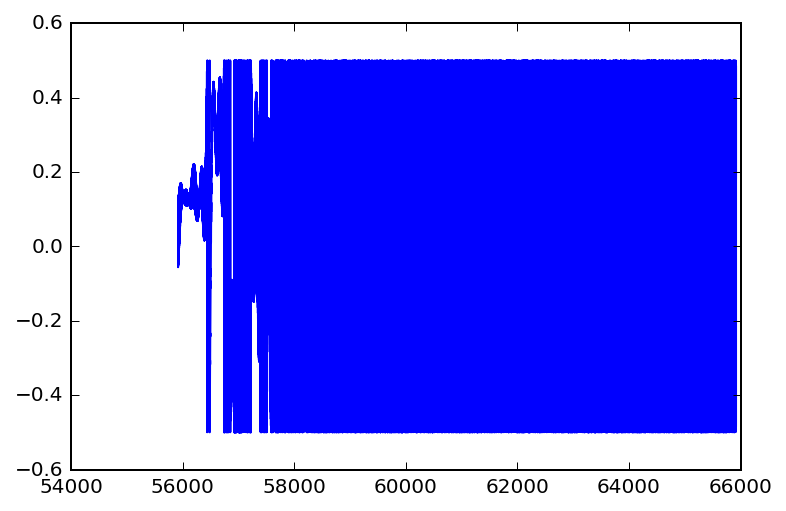

In [6]:
plt.plot(r.bary_TOA, r.prefit_phs)

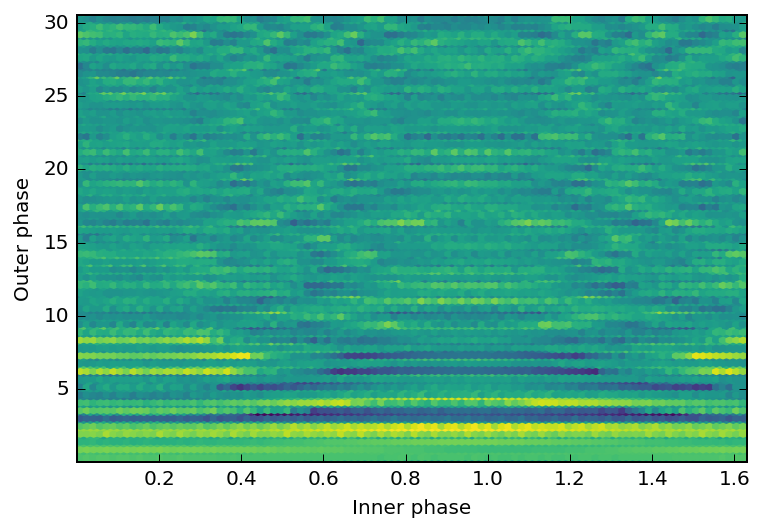

In [7]:
plt.hexbin(r.bary_TOA % pb_1,
           (r.bary_TOA - 55920)/pb_2,
           C = r.prefit_phs,
           bins=100)
plt.xlabel("Inner phase")
plt.ylabel("Outer phase")
#plt.colorbar()


In [8]:
mjds = []
timlines = []
pulses = []
with open(fake_toas, "rt") as f:
    for l in f.readlines():
        mjds.append(float(l.split()[2]))
        timlines.append(l)
with open(fake_pulses, "rt") as f:
    for l in f.readlines():
        pulses.append(l)


In [9]:
tempo2_key = """
T2
ECLOBL
IPM
DILATEFREQ
NO_SS_SHAPIRO
PLANET_SHAPIRO
CORRECT_TROPO
UNITS
NE1AU
TIMEEPH
T2CMETHOD
DMFACTOR
DMEPOCH
FDDC
FDDI
MSS
BINIT
SHAPMAX
KMPRA
KPMDEC
KPMELONG
KPMELAT
RV
RVS
VT
RACC
PMACC
D_SHK
D_AOP
D_OP
WAVE_FREQ
WAVES_1
WAVEC_1
TT(TAI)
""".split()

PSR              J0337+17    
RAJ      03:37:43.82589000
DECJ      17:15:14.8281000
POSEPOCH        56337.0000
F0    365.95334363837185548 1
F1      3.459285698888D-16  1  5.908704611672D-19
PEPOCH        55920.000000
START            55917.314
FINISH           56436.494
DM               21.313000
SOLARN0              10.00
CLK               UTC(NIST)   
NTOA                 26296
TRES                 38.47
TZRMJD             56100.0  1
TZRFRQ          999999.999
TZRSITE                  @
BINARY                 BTX     
PLAN  1
A1             1.217528496  1         0.000000010
E             0.0006802884  1        0.0000000154
T0         55917.574547351  1         0.000006180
OM         94.157681118988  1      0.001365536908
FB0     7.103160919367D-06  1  2.040868704844D-16
A1_2          74.668594264
E_2            0.035347540
T0_2       56317.235447282  1         0.000000705
PB_2      327.219804954111
OM_2       95.726944226135


0.917669581699 us


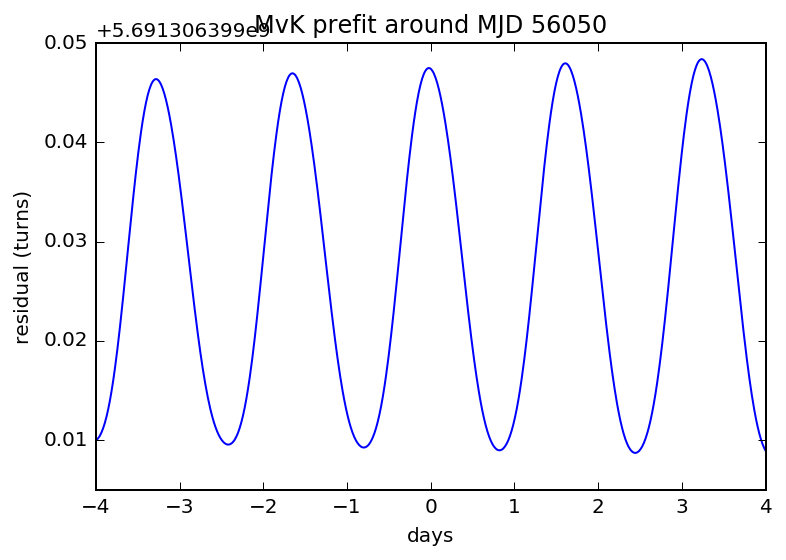

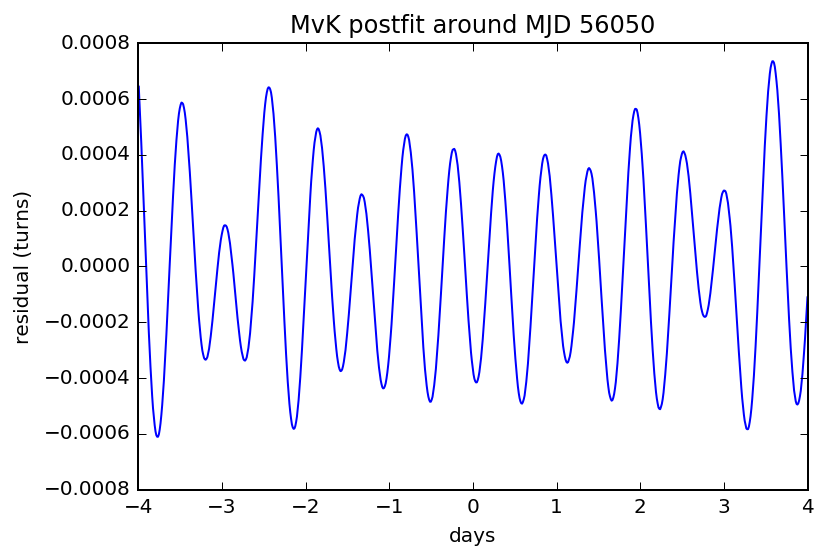

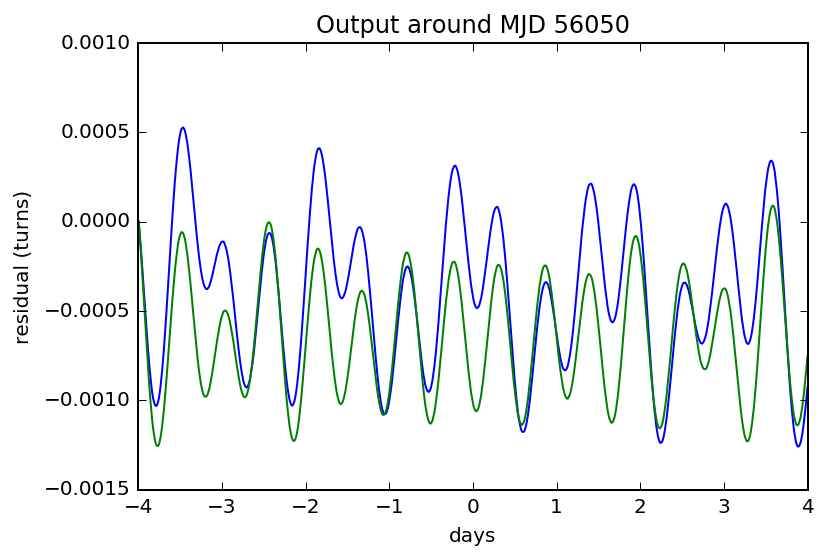

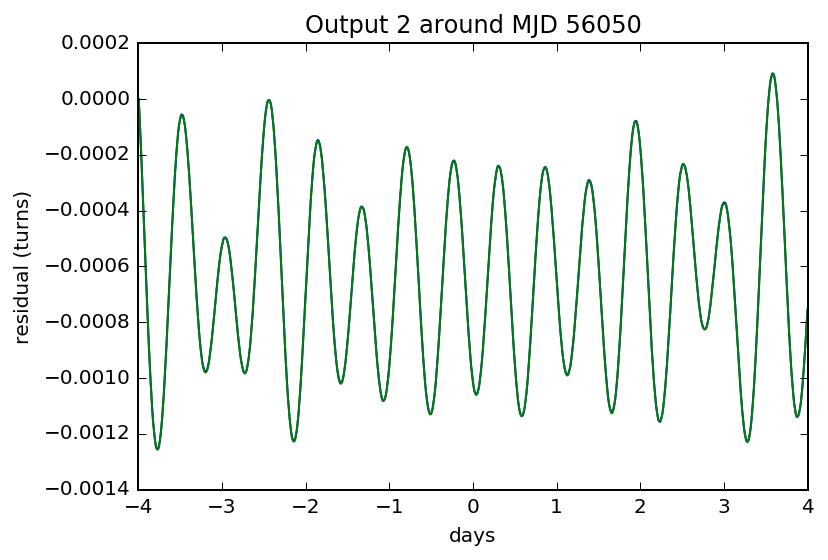

In [32]:
mjd_test = 56050
window = 8

par_fit_name = "0337+17_MvK_forfit.par"
with open(par_fit_name, "rt") as f:
    print f.read()

temp_tim = "temp.tim"
temp_pulses = "temp.pulses"
with open(temp_tim, "wt") as f:
    with open(temp_pulses, "wt") as g:
        for m,l,p in zip(mjds, timlines, pulses):
            if abs(m-mjd_test)<window/2:
                f.write(l)
                g.write(p)

pipe.check_call(["tempo", "-f", par_fit_name, "-ni", temp_pulses, temp_tim])
shutil.copy("J0337+17.par", "postfit.par")

r2 = residuals.read_residuals()

plt.plot(r2.bary_TOA-mjd_test, r2.prefit_phs)
plt.xlabel("days")
plt.ylabel("residual (turns)")
plt.title("MvK prefit around MJD %d" % mjd_test)
plt.figure()

plt.plot(r2.bary_TOA-mjd_test, r2.postfit_phs)
print np.sqrt(np.mean(r2.postfit_phs**2))/f0*1e6, "us"

plt.xlabel("days")
plt.ylabel("residual (turns)")
plt.title("MvK postfit around MJD %d" % mjd_test)

plt.figure()

pipe.check_call(["tempo", "-f", "postfit.par", "-ni", temp_pulses, temp_tim])
shutil.copy("J0337+17.par", "postfit2.par")
r3 = residuals.read_residuals()

plt.plot(r3.bary_TOA-mjd_test, r3.prefit_phs-r3.prefit_phs[0])
plt.xlabel("days")
plt.ylabel("residual (turns)")
plt.title("Output around MJD %d" % mjd_test)

plt.plot(r3.bary_TOA-mjd_test, r3.postfit_phs-r3.postfit_phs[0])

plt.figure()
pipe.check_call(["tempo", "-f", "postfit2.par", "-ni", temp_pulses, temp_tim])
r4 = residuals.read_residuals()

plt.plot(r4.bary_TOA-mjd_test, r4.prefit_phs-r4.prefit_phs[0])
plt.xlabel("days")
plt.ylabel("residual (turns)")
plt.title("Output 2 around MJD %d" % mjd_test)

plt.plot(r4.bary_TOA-mjd_test, r4.postfit_phs-r4.postfit_phs[0])


In [33]:
shutil.copy(par_fit_name, "J0337+17.par")
for i in range(10):
    pipe.check_call(["tempo", "-f", "J0337+17.par", "-ni", temp_pulses, temp_tim])
    r = residuals.read_residuals()
    print np.std(r.prefit_sec), np.mean(r.postfit_phs)
shutil.copy("J0337+17.par", "shortterm.par")

3.76112380448e-05 -5.14674043563e-06
1.14912679151e-06 -2.40377654253e-06
9.17601916038e-07 4.87446253652e-06
9.17592680915e-07 2.55831578142e-06
9.17670897673e-07 4.13945156297e-06
9.17584024675e-07 5.41684819688e-06
9.17730120574e-07 6.11863829967e-06
9.17619894486e-07 4.86223702793e-06
9.17701532722e-07 4.53953918545e-06
9.17629143514e-07 5.06870091364e-06


worst-case smearing 0.188115983911 us


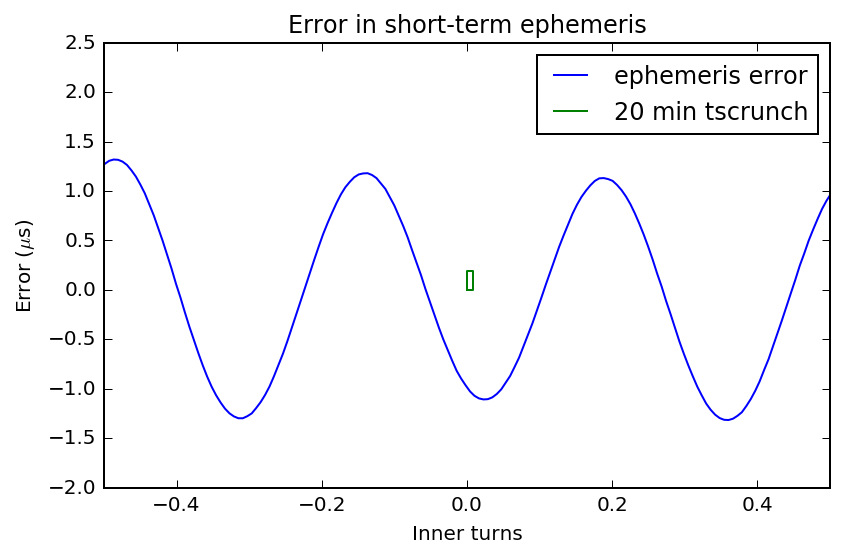

In [42]:
fb0 = 7.103159902785e-06
tscr = 20
plt.plot(fb0*86400*(r4.bary_TOA-mjd_test), 1e6*(r4.postfit_sec),
         color="blue", label="ephemeris error")
a = np.amax(r4.postfit_sec)-np.amin(r4.postfit_sec)
f = a*tscr*60*fb0*6*1e6
print "worst-case smearing", f, "us"
plt.plot([0,tscr*60*fb0,tscr*60*fb0,0,0],[0,0,f,f,0], color="green", label="20 min tscrunch")
plt.xlabel("Inner turns")
plt.ylabel(r"Error ($\mu$s)")
plt.xlim(-0.5,0.5)
#n,x = plt.xlim()
#plt.twiny()
#f = 24/(fb0*86400)
#plt.xlim(n*f,x*f)
#plt.xlabel("Hours")
plt.legend(loc="best")
plt.title("Error in short-term ephemeris")
plt.tight_layout()
plt.savefig("short-term-errors.pdf")

In [27]:
with open("shortterm.par", "rt") as f:
    print f.read()

PSR              J0337+17
RAJ      03:37:43.82589000
DECJ      17:15:14.8281000
POSEPOCH        56337.0000
F0    365.9531376996829408  1  0.0001806996644757
F1      1.671403515807D-11  1  1.469875443202D-11
PEPOCH        55920.000000
START            56048.006
FINISH           56051.998
DM               21.313000
SOLARN0              10.00
EPHEM               DE200
CLK                 UTC(NIST)                       
UNITS               TDB
TIMEEPH             FB90
T2CMETHOD           TEMPO
CORRECT_TROPOSPHERE N
PLANET_SHAPIRO      N
DILATEFREQ          N
NTOA                   400
TRES                  0.82
TZRMJD  56048.00722493509059
TZRFRQ           99999.999
TZRSITE                  @
MODE                     0
NITS                     1
BINARY            BTX     
PLAN  1
A1             1.217518223  1         0.000000090
E             0.0006746430  1        0.0000000981
T0        55917.5748529571  1        0.0000409800
OM         94.224849268188  1      0.008885892508
FB0     7.10

In [28]:
#test_file = "/psr_archive/hessels/archibald/0337+17/raw/GBT/guppi_56050_0337+17_0008.forTOAs"
test_file = "/psr_archive/hessels/archibald/0337+17/raw/AO/puppi_56554_J0337+1715_0223_0001.fits"

td = "/tmp/segment_test"
if not os.path.exists(td):
    os.mkdir(td)

env = os.environ.copy()
#for (k,v) in sorted(env.items()):
#    print k, ":", v
#del env['TEMPO2']
#del env['TEMPO']
#del env['PSRHOME']



P = subprocess.Popen(["pam", "-E", "shortterm.par", "-u", td, test_file],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE,
                    env=env)
out, err = P.communicate()
print out
print err
if P.returncode:
    raise ValueError("Returned code %s" % P.returncode)

/tmp/segment_test/puppi_56554_J0337+1715_0223_0001.fits written to disk




56554.331954
(64, 2048)


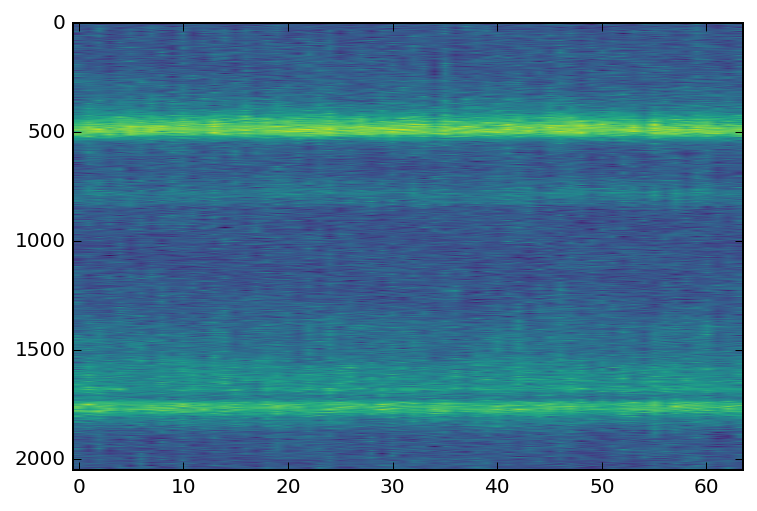

In [56]:
F = psrchive.Archive_load(test_file)

print F.start_time().in_days()
F.pscrunch()
F.fscrunch()
F.remove_baseline()

d = np.squeeze(F.get_data())
print d.shape
plt.imshow(d.T)
plt.gca().set_aspect('auto')

(64, 2048)


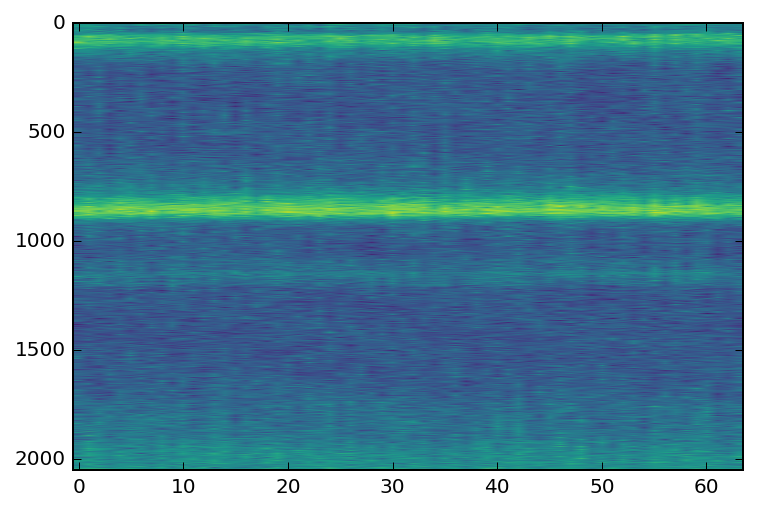

In [57]:
G = psrchive.Archive_load(os.path.join(td,os.path.basename(test_file)))


G.pscrunch()
G.fscrunch()
G.remove_baseline()

d = np.squeeze(G.get_data())
print d.shape
plt.imshow(d.T)
plt.gca().set_aspect('auto')

In [58]:
with open("shortterm-tzr.par", "wt") as f:
    for l in open("shortterm.par", "rt").readlines():
        if l.startswith("TZRMJD"):
            tzrmjd_s = l.split()[1]
            tzrmjd_i = int(tzrmjd_s.split(".")[0])
            tzrmjd_f = float("0."+tzrmjd_s.split(".")[1])
            tzrmjd_f += 1e-3/86400
            f.write("TZRMJD %d.%s\n" % (tzrmjd_i, ("%.16f" % tzrmjd_f)[2:]))
        else:
            f.write(l)
print open("shortterm-tzr.par").read()


PSR              J0337+17    
RAJ      03:37:43.82589000
DECJ      17:15:14.8281000
POSEPOCH        56337.0000
F0    365.9533436429024391  1  0.0000002502769402
F1      4.236742179264D-16  1  7.814829459879D-14
PEPOCH        56100.000000
START            56042.007
FINISH           56057.997
DM               21.313000
SOLARN0              10.00
EPHEM               DE200
CLK                 UTC(NIST)   
UNITS               TDB
TIMEEPH             FB90
T2CMETHOD           TEMPO
CORRECT_TROPOSPHERE N
PLANET_SHAPIRO      N
DILATEFREQ          N
NTOA                  1600
TRES                  1.13
TZRMJD 56100.0000000115740741
TZRFRQ          999999.999
TZRSITE                  @
NITS                     1
BINARY            BTX     
PLAN  1
A1             1.217518144  1         0.000000040
E             0.0006743484  1        0.0000000662
T0         55917.574768480  1         0.000025342
OM         94.208281003295  1      0.005595932148
FB0     7.103159902785D-06  1  1.351714248828D-14
A1_2

In [59]:
P = subprocess.Popen(["pam", "-E", "shortterm-tzr.par", "-u", td, test_file],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE,
                    env=env)
out, err = P.communicate()
print out
print err
if P.returncode:
    raise ValueError("Returned code %s" % P.returncode)

/tmp/segment_test/puppi_56554_J0337+1715_0223_0001.fits written to disk




(64, 2048)


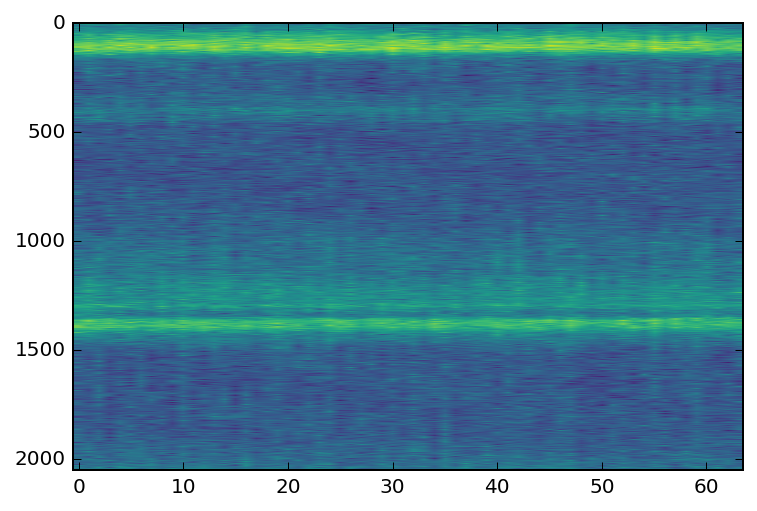

In [60]:
H = psrchive.Archive_load(os.path.join(td,os.path.basename(test_file)))


H.pscrunch()
H.fscrunch()
H.remove_baseline()

d = np.squeeze(H.get_data())
print d.shape
plt.imshow(d.T)
plt.gca().set_aspect('auto')

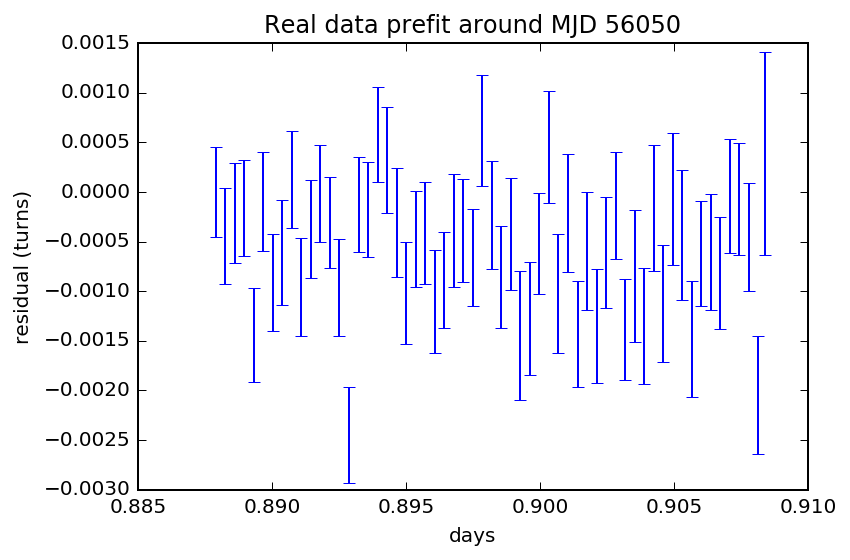

In [61]:
sample_toas_file = "sample.tim"
with open(sample_toas_file,"wt") as f:
    f.write("""
1               1496.634 56050.8928262985111    1.250
1               1496.634 56050.8931818394096    1.329
1               1496.634 56050.8935373803175    1.366
1               1496.634 56050.8938928895786    1.309
1               1496.634 56050.8942484304145    1.285
1               1496.634 56050.8946039713213    1.356
1               1496.634 56050.8949595121475    1.331
1               1496.634 56050.8953150213680    1.444
1               1496.634 56050.8956705622191    1.343
1               1496.634 56050.8960260713713    1.360
1               1496.634 56050.8963816438219    1.355
1               1496.634 56050.8967371529950    1.336
1               1496.634 56050.8970926937642    1.252
1               1496.634 56050.8974482028807    1.340
1               1496.634 56050.8978037752160    1.327
1               1496.634 56050.8981592527729    1.295
1               1496.634 56050.8985147935000    1.304
1               1496.634 56050.8988703658688    1.308
1               1496.634 56050.8992258749354    1.466
1               1496.634 56050.8995814156065    1.504
1               1496.634 56050.8999369562624    1.404
1               1496.634 56050.9002924653163    1.320
1               1496.634 56050.9006480059712    1.405
1               1496.634 56050.9010035465898    1.418
1               1496.634 56050.9013590555951    1.322
1               1496.634 56050.9017145962258    1.559
1               1496.634 56050.9020701684565    1.409
1               1496.634 56050.9024256457791    1.332
1               1496.634 56050.9027811863956    1.526
1               1496.634 56050.9031367585608    1.489
1               1496.634 56050.9034922674624    1.401
1               1496.634 56050.9038477763846    1.545
1               1496.634 56050.9042033485052    1.776
1               1496.634 56050.9045588573931    1.560
1               1496.634 56050.9049144611728    1.387
1               1496.634 56050.9052699384308    1.536
1               1496.634 56050.9056254472268    1.635
1               1496.634 56050.9059809877113    1.623
1               1496.634 56050.9063365281179    1.458
1               1496.634 56050.9066921002056    1.624
1               1496.634 56050.9070476406005    1.574
1               1496.634 56050.9074030861426    1.528
1               1496.634 56050.9077586581788    1.470
1               1496.634 56050.9081142301469    1.388
1               1496.634 56050.9084697705293    1.809
1               1496.634 56050.9088252792363    1.593
1               1496.634 56050.9091807563545    1.731
1               1496.634 56050.9095362966491    1.610
1               1496.634 56050.9098918686225    1.811
1               1496.634 56050.9102474089088    1.786
1               1496.634 56050.9106029491599    1.604
1               1496.634 56050.9109583945710    1.452
1               1496.634 56050.9113139980861    1.599
1               1496.634 56050.9116695383223    1.549
1               1496.634 56050.9120250785762    1.563
1               1496.634 56050.9123806187909    1.553
1               1496.634 56050.9127360640940    1.489
1               1496.634 56050.9130916358604    1.623
1               1496.634 56050.9133286943504    2.798
""")

pipe.check_call(["tempo", "-f", "shortterm.par", sample_toas_file])
r = residuals.read_residuals()

plt.errorbar(r.bary_TOA-mjd_test, r.prefit_phs, r.uncertainty*f0, linestyle='none')
plt.xlabel("days")
plt.ylabel("residual (turns)")
plt.title("Real data prefit around MJD %d" % mjd_test)


In [62]:
!pat -h

pat - Pulsar::Archive timing 
Usage: pat [options] filenames 
  -q               Quiet mode 
  -v               Verbose mode 
  -V               Very verbose mode 
  -i               Show revision information 
  -M metafile      List of archive filenames in metafile 

Preprocessing options:
  -F               Frequency scrunch before fitting 
  -T               Time scrunch before fitting 
  -j job1[,jobN]   Preprocessing job[s] 
  -J jobs          Multiple preprocessing jobs in 'jobs' file 
  -d               Discard profiles with zero weight
  -x               Disable default preprocessing 

Fitting options:
  -a stdfiles      Automatically select standard from specified group
  -D               Denoise standard 
  -e cfg1[,cfgN]   Estimator configuration option[s] 
  -E cfg           Estimator configuration options in 'cfg' text file 
  -g datafile      Gaussian model fitting 
  -s stdfile       Location of standard profile 
  -S period        Zap harmonics due to periodic spikes in

In [63]:
template = "GUPPI_0337+17_55998_85890_0001.newephem"
pat_toas = subprocess.check_output(["pat", "-Fd", "-s", template, test_file])

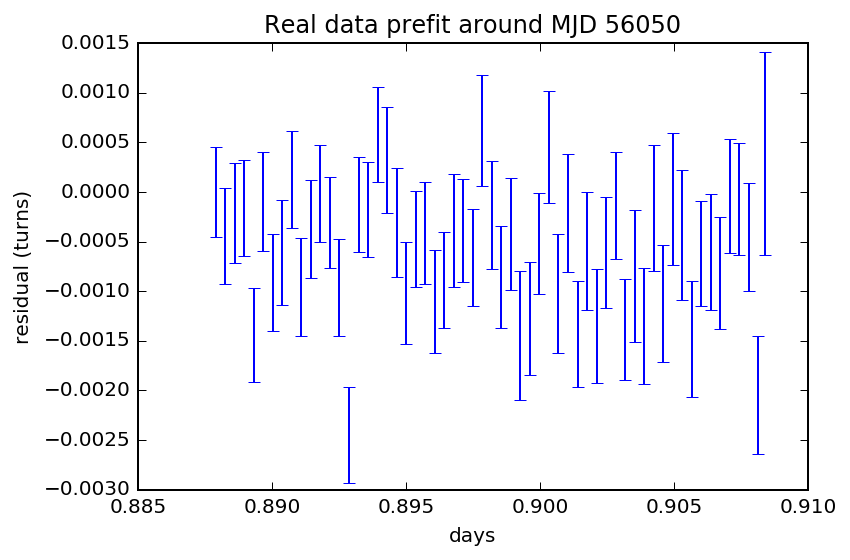

In [64]:
pat_toas_file = "pat.tim"
with open(pat_toas_file,"wt") as f:
    f.write(pat_toas)

pipe.check_call(["tempo", "-f", "shortterm.par", sample_toas_file])
r = residuals.read_residuals()

plt.errorbar(r.bary_TOA-mjd_test, r.prefit_phs, r.uncertainty*f0, linestyle='none')
plt.xlabel("days")
plt.ylabel("residual (turns)")
plt.title("Real data prefit around MJD %d" % mjd_test)


In [65]:
par_db = pipe.EphemerisCollection(directory="/psr_archive/hessels/archibald/0337+17/ephemerides/")

F = psrchive.Archive_load(test_file)
mjd = (F.get_Integration(0).get_start_time().in_days()
    +F.get_Integration(len(F)-1).get_end_time().in_days())/2
par = par_db.get_par_for(mjd)
pipe.check_call(["pam", "-E", par, "-u", td, test_file])
G = psrchive.Archive_load(os.path.join(td,os.path.basename(test_file)))



In [66]:
r = residuals.read_residuals()
print np.std(r.prefit_sec), np.mean(r.postfit_phs)

1.6741568939e-06 2.15843132444e-10


(2048,)
(2048,)


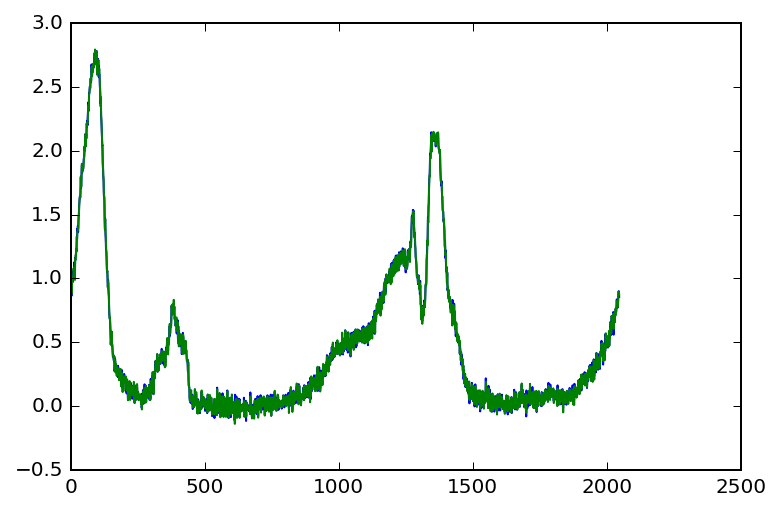

In [67]:
G = psrchive.Archive_load(os.path.join(td,os.path.basename(test_file)))

G.pscrunch()
G.fscrunch()
G.tscrunch()
G.remove_baseline()

d = np.squeeze(G.get_data())
print d.shape
plt.plot(d)

par2 = par_db.get_par_for(mjd-4)
pipe.check_call(["pam", "-E", par2, "-u", td, test_file])
H = psrchive.Archive_load(os.path.join(td,os.path.basename(test_file)))

H.pscrunch()
H.fscrunch()
H.tscrunch()
H.remove_baseline()

d = np.squeeze(H.get_data())
print d.shape
plt.plot(d)

